In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.utils import load_img, img_to_array, to_categorical
from tensorflow.python.client import device_lib 
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Model
print(device_lib.list_local_devices())


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1310074147497486577
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 1721342363
locality {
  bus_id: 1
  links {
  }
}
incarnation: 12499352298312412110
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3050 Ti Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6"
xla_global_id: 416903419
]


In [2]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
for gpu_instance in physical_devices:
    tf.config.experimental.set_memory_growth(gpu_instance, True)

In [3]:
image_width, image_height = 256, 256
data_dir = 'Cropped'

In [4]:
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(image_width, image_height),
    batch_size=16,
    class_mode='categorical',
    subset='training')

validation_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(image_width, image_height),
    batch_size=16,
    class_mode='categorical',
    subset='validation')

Found 1520 images belonging to 2 classes.
Found 380 images belonging to 2 classes.


In [5]:
num_classes = len(train_generator.class_indices)

In [6]:
input_shape = (image_width, image_height, 3)
inputs = Input(shape=input_shape)

x = Conv2D(8, (3, 3), activation='relu', padding='same')(inputs)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(16, (2, 2), activation='relu', strides=(2,2))(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding = 'same')(x)
x = Conv2D(64, (2, 2), activation='relu', strides=(2,2))(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Flatten()(x)
x = Dense(32, activation='relu')(x)
outputs = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

In [7]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 8)       224       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 8)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 16)        528       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 16)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 32)        4640  

In [8]:
optimizer = Adam(lr=0.0001)
loss = CategoricalCrossentropy()
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator)

C:\Users\mihir\anaconda3\envs\tf_gpu\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/10
95/95 [==============================] - 17s 62ms/step - loss: 0.6844 - accuracy: 0.5632 - val_loss: 0.6650 - val_accuracy: 0.5000
Epoch 2/10
95/95 [==============================] - 5s 50ms/step - loss: 0.5966 - accuracy: 0.8664 - val_loss: 0.4749 - val_accuracy: 1.0000
Epoch 3/10
95/95 [==============================] - 4s 45ms/step - loss: 0.2374 - accuracy: 0.9987 - val_loss: 0.0533 - val_accuracy: 1.0000
Epoch 4/10
95/95 [==============================] - 4s 47ms/step - loss: 0.0213 - accuracy: 1.0000 - val_loss: 0.0090 - val_accuracy: 1.0000
Epoch 5/10
95/95 [==============================] - 4s 46ms/step - loss: 0.0044 - accuracy: 1.0000 - val_loss: 0.0027 - val_accuracy: 1.0000
Epoch 6/10
95/95 [==============================] - 4s 47ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.0013 - val_accuracy: 1.0000
Epoch 7/10
95/95 [==============================] - 4s 45ms/step - loss: 7.0775e-04 - accuracy: 1.0000 - val_loss: 6.9530e-04 - val_accuracy: 1.0000
Epoc

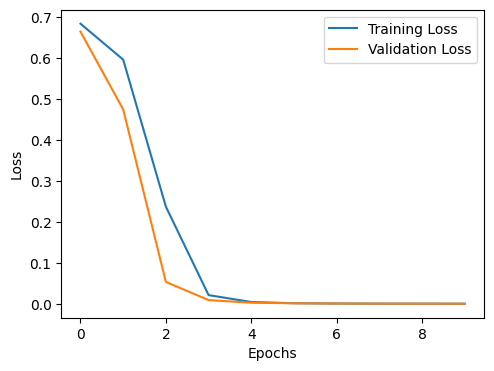

In [9]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

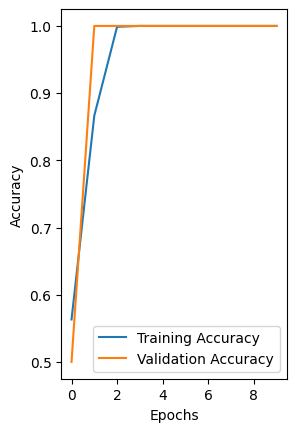

In [10]:
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()


In [12]:
label_map = {v: k for k, v in train_generator.class_indices.items()}
def get_labels(predictions):
    return [label_map[np.argmax(prediction)] for prediction in predictions]

In [13]:
label_map

{0: 'decayed', 1: 'fresh'}

In [14]:
import cv2

In [15]:
folder1 = 'test/fresh'
folder2 = 'test/decayed'

In [16]:
def load_images_from_folder(folder, target_size=(256, 256)):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename))
        images.append(img)
    return images

images1 = load_images_from_folder(folder1)
labels1 = ['fresh']*50
images2 = load_images_from_folder(folder2)
labels2 = ['decayed']*50

test_images = images1 + images2
test_labels = labels1+labels2
test_images = np.array(test_images)

In [17]:
test_images = test_images / 255.0

# Predict labels for test images
predictions = model.predict(test_images)
labels = get_labels(predictions)

# Display predicted labels
for i, label in enumerate(labels):
    print(f"Image {i + 1}: {label}")

4/4 [==============================] - 1s 36ms/step
Image 1: fresh
Image 2: fresh
Image 3: fresh
Image 4: fresh
Image 5: fresh
Image 6: fresh
Image 7: fresh
Image 8: fresh
Image 9: fresh
Image 10: fresh
Image 11: fresh
Image 12: fresh
Image 13: fresh
Image 14: fresh
Image 15: fresh
Image 16: fresh
Image 17: fresh
Image 18: fresh
Image 19: fresh
Image 20: fresh
Image 21: fresh
Image 22: fresh
Image 23: fresh
Image 24: fresh
Image 25: fresh
Image 26: fresh
Image 27: fresh
Image 28: fresh
Image 29: fresh
Image 30: fresh
Image 31: fresh
Image 32: fresh
Image 33: fresh
Image 34: fresh
Image 35: fresh
Image 36: fresh
Image 37: fresh
Image 38: fresh
Image 39: fresh
Image 40: fresh
Image 41: fresh
Image 42: fresh
Image 43: fresh
Image 44: fresh
Image 45: fresh
Image 46: fresh
Image 47: fresh
Image 48: fresh
Image 49: fresh
Image 50: fresh
Image 51: decayed
Image 52: decayed
Image 53: decayed
Image 54: decayed
Image 55: decayed
Image 56: decayed
Image 57: decayed
Image 58: decayed
Image 59: dec

In [18]:
correct_predictions = sum([predicted_label == true_label for predicted_label, true_label in zip(labels, test_labels)])

In [19]:
print(correct_predictions,'%')

100 %


In [20]:
!pip install pydot graphviz

  Using cached pydot-1.4.2-py2.py3-none-any.whl (21 kB)
  Using cached graphviz-0.20.1-py3-none-any.whl (47 kB)


In [22]:
from tensorflow.keras.utils import plot_model

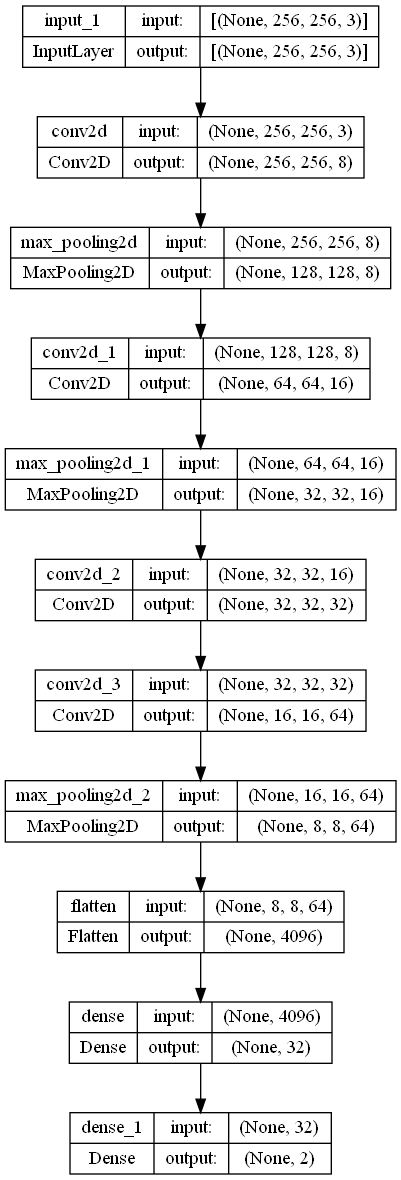

In [23]:
plot_model(model, to_file='model_diagram.png', show_shapes=True, show_layer_names=True)